# Advanced SQL Analysis with Chinook
*Focus: Window Functions · Aggregate Filtering (HAVING) · Business Insights*

**Project context:** Uncovering trends and performance metrics to inform marketing and catalog decisions. The Chinook database contains data on customers, invoices, tracks, albums, artists, and genres. 

**1. Who are our top customers based on total purchases, and how do they compare to the average customer?**
- **Goal:** Use SUM(), GROUP BY, and a HAVING clause to find high-value customers.
- **Skills:** Aggregation, HAVING, Sorting

*“This query helps identify VIP customers for potential loyalty or referral campaigns.”*

In [24]:
# Download all necessary libraries and connect to the database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the database
conn = sqlite3.connect('Chinook_dataset.sqlite')


In [25]:
# Query 1 : Identify top customers compared to the average spent per customer 
query = '''
WITH sum_total AS 
(SELECT CustomerID, SUM(Total) as total_spent FROM Invoice GROUP BY CustomerID),
avg_total AS(
SELECT AVG(total_spent) as avg_spent_per_customer FROM sum_total)
SELECT 
c.FirstName ||' ' || c.LastName as CustomerName, 
s.total_spent , (Select avg_spent_per_customer FROM avg_total) as avg_spent_per_customer
FROM Customer c JOIN sum_total s on c.CustomerID = s.CustomerID
ORDER BY total_spent DESC
LIMIT 20;  
'''
df = pd.read_sql_query(query, conn)

#### Question 1 – Top customers vs. average customer  
I first calculated the average per order, but that ignored multiple orders per customer.  
Next I summed totals per customer, computed the average of those totals, and experimented with different LIMITs.  
Key finding: every top‑20 customer spent > €35, while the average spend per customer is ~€39.


C:\Users\Teo\AppData\Local\Temp\ipykernel_2304\563065673.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




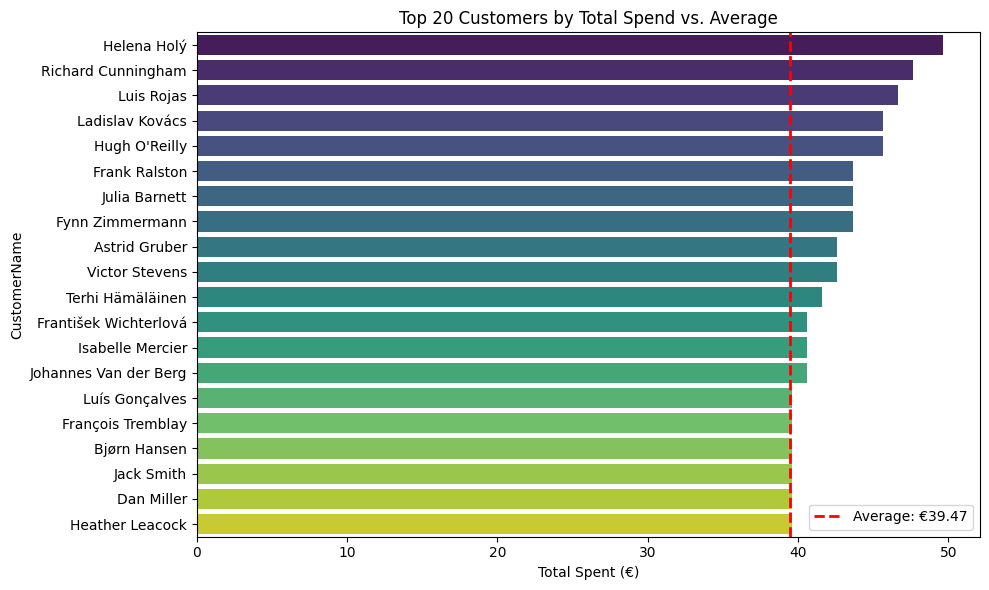

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x='total_spent',
    y='CustomerName',
    palette='viridis' 
)

average = df['avg_spent_per_customer'].iloc[0]
plt.axvline(average, color='red', linestyle='--', linewidth=2,
            label=f'Average: €{average:.2f}')

plt.xlabel('Total Spent (€)')
plt.title('Top 20 Customers by Total Spend vs. Average')
plt.legend()
plt.tight_layout()
plt.show()



**2. Which albums generate the most revenue, and how do they rank within the artist’s full catalog?**
- **Goal:** Calculate album revenue (via track unit price), and use RANK() or DENSE_RANK() over each artist’s albums.
- **Skills:** Window Functions, JOINs, Aggregation

*“Useful for contract renegotiations or artist-focused marketing — reveals which albums are driving income per artist.”*

**Process:** 
- I first calculated revenue per album and ranked albums within each artist using SQL window functions (RANK() OVER (PARTITION BY...)).

- Then I identified the top 20 albums overall by revenue to highlight high performers.

- Finally, I summed revenue per artist to find the top 20 highest-earning artists.

**Visualizations:**

- The first plot shows the top 3 albums by revenue per artist (for a sample of 4 artists), demonstrating how revenue is distributed within an artist’s catalog.

- The second plot highlights the top 20 individual albums by revenue, revealing the biggest revenue drivers.

- The third plot summarizes total revenue by artist, showing the most commercially successful artists in the dataset.



In [ ]:
# Query 2: Album revenue with rank within each artist
query_ranked_albums = '''
WITH AlbumRevenue AS (
    SELECT 
        a.AlbumId,
        a.Title,
        ar.Name AS ArtistName,
        SUM(il.Quantity * il.UnitPrice) AS RevenuePerAlbum
    FROM Track t
    JOIN InvoiceLine il ON t.TrackId = il.TrackId
    JOIN Album a ON a.AlbumId = t.AlbumId
    JOIN Artist ar ON a.ArtistId = ar.ArtistId
    GROUP BY a.AlbumId
)
SELECT
    AlbumId,
    Title,
    ArtistName,
    RevenuePerAlbum,
    RANK() OVER (PARTITION BY ArtistName ORDER BY RevenuePerAlbum DESC) AS AlbumRank
FROM AlbumRevenue
ORDER BY ArtistName, AlbumRank;
'''
df_ranked_albums = pd.read_sql_query(query_ranked_albums, conn)

# Query 3: Top 20 albums by revenue
query_top_albums = '''
SELECT 
    a.Title,
    ar.Name AS ArtistName,
    SUM(il.Quantity * il.UnitPrice) AS RevenuePerAlbum
FROM Track t
JOIN InvoiceLine il ON t.TrackId = il.TrackId
JOIN Album a ON a.AlbumId = t.AlbumId
JOIN Artist ar ON a.ArtistId = ar.ArtistId
GROUP BY a.AlbumId
ORDER BY RevenuePerAlbum DESC
LIMIT 20;
'''
df_top_albums = pd.read_sql_query(query_top_albums, conn)

# Query 4: Top 20 artists by total revenue
query_top_artists = '''
SELECT 
    ar.Name AS ArtistName,
    SUM(il.Quantity * il.UnitPrice) AS RevenuePerArtist
FROM Track t
JOIN InvoiceLine il ON t.TrackId = il.TrackId
JOIN Album a ON a.AlbumId = t.AlbumId
JOIN Artist ar ON a.ArtistId = ar.ArtistId
GROUP BY ar.ArtistId
ORDER BY RevenuePerArtist DESC
LIMIT 20;
'''
df_top_artists = pd.read_sql_query(query_top_artists, conn)

conn.close()



In [47]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Ensure numeric rank
df_ranked_albums['AlbumRank'] = pd.to_numeric(df_ranked_albums['AlbumRank'])

# Dropdown of artist names
artist_dropdown = widgets.Dropdown(
    options=sorted(df_ranked_albums['ArtistName'].unique()),
    description='Artist:',
)

def plot_artist(artist_name):
    sub = (df_ranked_albums.query("ArtistName == @artist_name")
                           .sort_values("AlbumRank"))
    fig = px.bar(
    sub,
    x='RevenuePerAlbum',
    y='Title',
    orientation='h',
    color='AlbumRank',
    color_continuous_scale='viridis',
    labels={'RevenuePerAlbum': 'Revenue (€)', 'Title': 'Album'},
    title=f'Album Revenue Ranking – {artist_name}'
)
    fig.update_layout(
        yaxis_categoryorder = 'total ascending',
        coloraxis_showscale=False
        )
    fig.show()


widgets.interact(plot_artist, artist_name=artist_dropdown);

interactive(children=(Dropdown(description='Artist:', options=('AC/DC', 'Academy of St. Martin in the Fields &…

C:\Users\Teo\AppData\Local\Temp\ipykernel_2304\3252317535.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




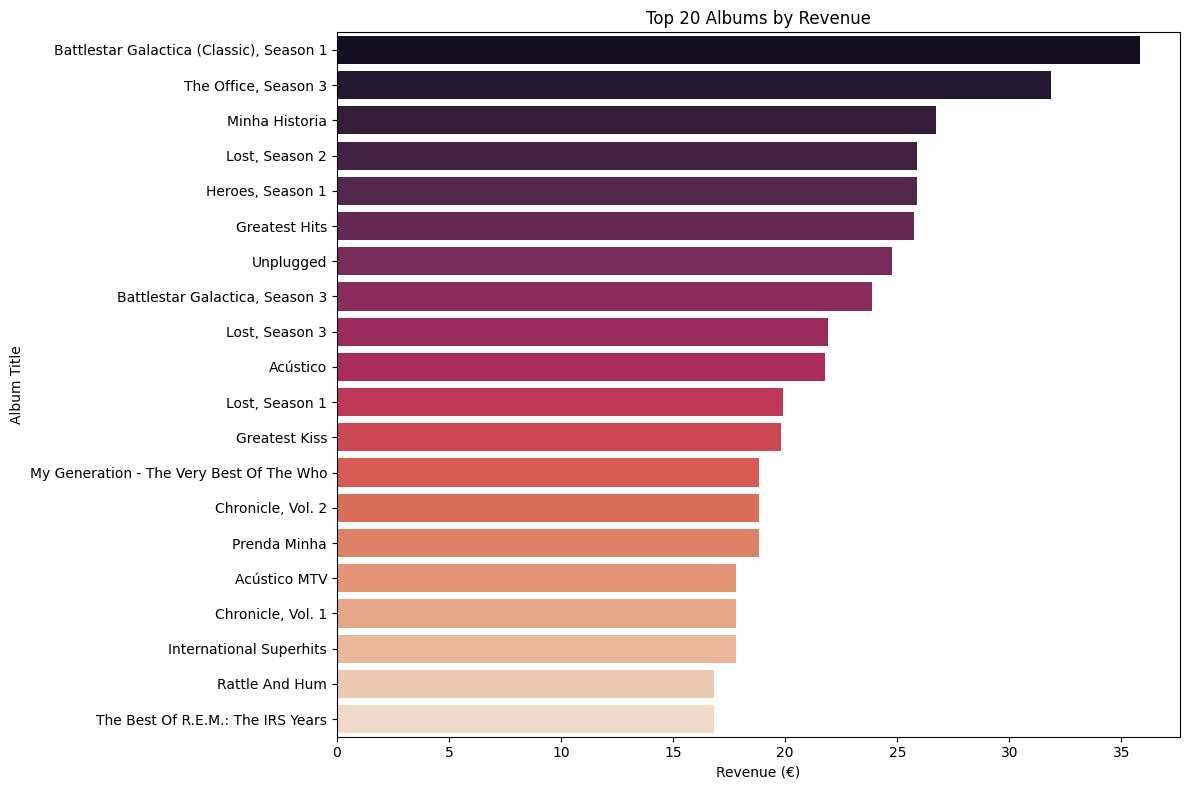

In [45]:

# Plot 2: Top 20 albums by revenue
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_top_albums.sort_values('RevenuePerAlbum', ascending=False),
    y='Title',
    x='RevenuePerAlbum',
    palette='rocket'
)
plt.title('Top 20 Albums by Revenue')
plt.xlabel('Revenue (€)')
plt.ylabel('Album Title')
plt.tight_layout()
plt.show()

C:\Users\Teo\AppData\Local\Temp\ipykernel_2304\37890417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


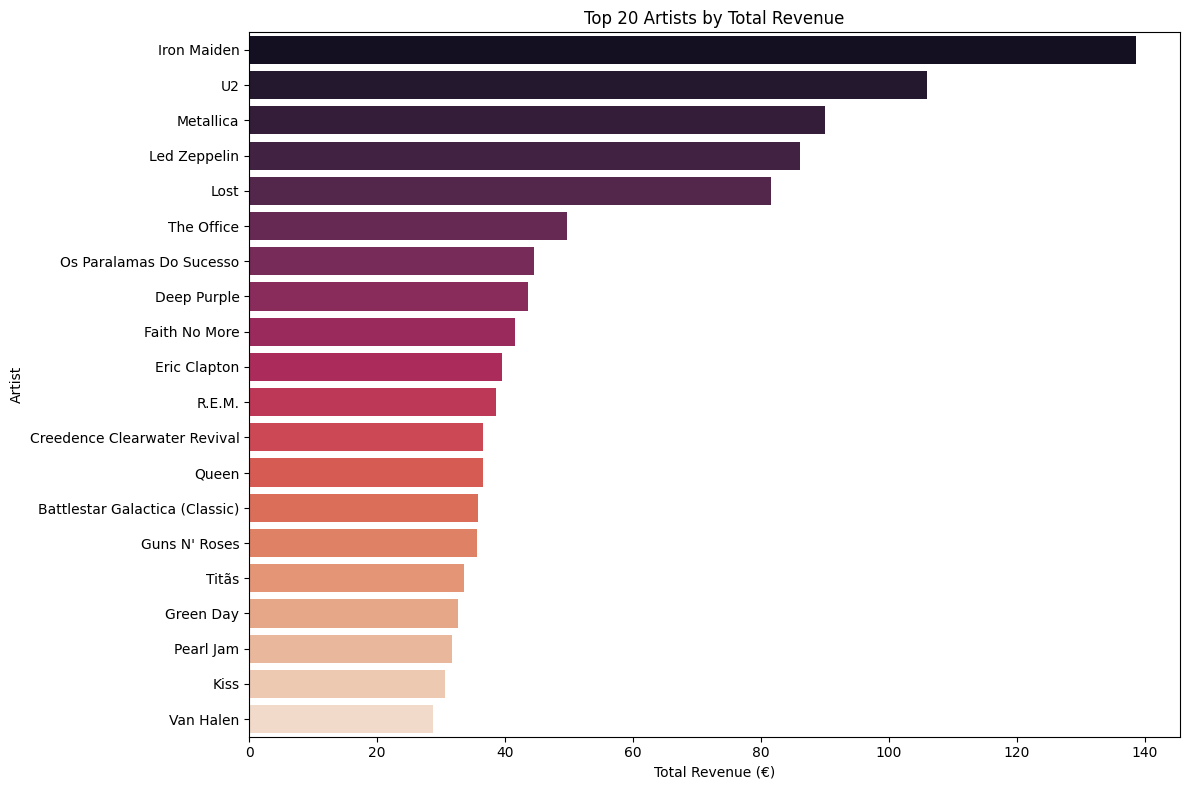

In [30]:


# Plot 3: Top 20 artists by total revenue
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_top_artists.sort_values('RevenuePerArtist', ascending=False),
    y='ArtistName',
    x='RevenuePerArtist',
    palette='rocket'
)
plt.title('Top 20 Artists by Total Revenue')
plt.xlabel('Total Revenue (€)')
plt.ylabel('Artist')
plt.tight_layout()
plt.show()

